In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway # 分散分析
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import os

### ファイルの読み込み

In [2]:
train_data = pd.read_csv('../data/original/train.csv')
test_data = pd.read_csv('../data/original/test.csv')

train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### 基本的な変数

In [3]:
obj_column = 'SalePrice'

In [4]:
def histogram(df):# 各列に対してヒストグラムを出力
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            plt.hist(df[column], bins=50, edgecolor='black')  # ビン数やエッジカラーは適宜調整可能
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.savefig(f'../data/output/histogram_{column}.jpg')
        else:
            # 各カテゴリの出現数を計算
            category_counts = df[column].value_counts()
            # ヒストグラムのプロット
            plt.bar(category_counts.index, category_counts.values, edgecolor='black')
            plt.title(f'Histogram of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.savefig(f'../data/output/histogram_{column}.jpg')

In [5]:
def scatter(df):
    for column in df.columns:
        if column == obj_column:
            continue  # 目的変数はスキップ
        if pd.api.types.is_numeric_dtype(df[column]):
            # Aが数値変数の場合は散布図
            sns.scatterplot(x=column, y=obj_column, data=df)
            plt.title(f'Scatter Plot of {obj_column} and {column}')
        else:
            # Aがカテゴリ変数の場合はバイオリンプロット
            sns.violinplot(x=column, y=obj_column, data=df)
            plt.title(f'Violin Plot of {obj_column} and {column}')
        
        plt.xlabel(column)
        plt.ylabel(obj_column)

        plt.savefig(f'../data/output/scatter_{column}.jpg')
        plt.show()

In [7]:
from openpyxl import Workbook
from openpyxl.drawing.image import Image

def generate_alphabets(N):
    result = []
    current = ['A']
    
    while len(result) < N:
        result.append(''.join(current))
        carry = 1

        for i in range(len(current)-1, -1, -1):
            current_sum = ord(current[i]) - ord('A') + carry
            current[i] = chr((current_sum % 26) + ord('A'))
            carry = current_sum // 26

        if carry:
            current.insert(0, 'A')

    return result

def summary_initialdata(data, features, filename):
    # フォルダAとフォルダBのパスを指定
    folder_a_path = "../data/output/scatter/"
    folder_b_path = "../data/output/histogram/"
    # Excelファイルを作成
    wb = Workbook()
    ws = wb.active

    # あとで使う変数の定義
    alphabets = generate_alphabets(len(features))
    string_cell_width = 20
    img_cell_width_ratio = 1/7
    dic = {column: j for j, column in enumerate(data)}

    # 特徴量の追加
    for i, f in enumerate(features):
        ws[alphabets[i]+str(1)] = f
        if f == '変数名':
            # 変数名を追加する
            for j, name in enumerate(data):
                ws[alphabets[i]+str(j+2)] = name
            ws.column_dimensions[alphabets[i]].width = string_cell_width
        if f == '相関係数':
            for j, name in enumerate(data):
                if pd.api.types.is_numeric_dtype(data[name]):
                    ws[alphabets[i]+str(int(dic[name])+2)] = data[obj_column].corr(data[name])
        if f == '分散分析（p値）':
            for j, name in enumerate(data):
                if not pd.api.types.is_numeric_dtype(data[name]):
                    data_tmp = data.copy()
                    data_tmp = data_tmp.dropna(subset=[name])
                    result = f_oneway(*[data_tmp[obj_column][data_tmp[name] == category] for category in data_tmp[name].unique()])
                    ws[alphabets[i]+str(int(dic[name])+2)] = result.pvalue
        if f == '散布図':
            # scatter画像の読み込み
            for filename in os.listdir(folder_a_path):
                if filename.endswith(".jpg"):
                    column = filename.split("_")[1].split(".")[0]
                    img_path = os.path.join(folder_a_path, filename)
                    # 画像をExcelに挿入
                    img = Image(img_path)
                    # 画像サイズの変更
                    img.height /= 2
                    img.width /= 2
                    ws.add_image(img, alphabets[i]+str(int(dic[column])+2))
            ws.column_dimensions[alphabets[i]].width = img.width*img_cell_width_ratio
        if f == 'ヒストグラム':
            # histogram画像の読み込み   
            for filename in os.listdir(folder_b_path):
                if filename.endswith(".jpg"):
                    column = filename.split("_")[1].split(".")[0]
                    img_path = os.path.join(folder_b_path, filename)
                    # 画像をExcelに挿入
                    img = Image(img_path)
                    # 画像サイズの変更
                    img.height /= 2
                    img.width /= 2
                    ws.add_image(img, alphabets[i]+str(int(dic[column])+2))
            ws.column_dimensions[alphabets[i]].width = img.width*img_cell_width_ratio


    for i in range(len(data)):
        ws.row_dimensions[i+2].height = img.height/1.2

    # Excelファイルを保存
    wb.save(filename)

In [12]:
# scatter(train_data)
features = ['変数名', '相関係数', '分散分析（p値）', '散布図', 'ヒストグラム']
filename = '../data/output/initial_analysis.xlsx'
train_data_dn = train_data.copy()
train_data_dn = train_data_dn.dropna()
print(len(train_data), len(train_data_dn))
summary_initialdata(train_data, features, filename)

1460 0


In [8]:
def missing_list(data):
    # 変数ごとに欠損値の数とそれ以外の数を計算する
    missing_data_info = pd.DataFrame({
        '変数名': data.columns,
        '欠損値の数': data.isnull().sum(),
        'それ以外の数': data.notnull().sum()
    })

    # 結果を出力する
    # 表示オプションを変更してすべての行と列を省略せずに表示
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    print(missing_data_info)

    pd.set_option('display.max_rows', 20)
    pd.set_option('display.max_columns', 10)

In [9]:
def LR(x, y):
    reg = LinearRegression()
    reg.fit(x, y)
    return reg

In [22]:
# 線形回帰の場合はカテゴリ変数をエンコーディングする必要がある。
# reg = LR(np.array(train_data.drop(obj_column, axis=1)), np.array(train_data)[obj_column])

# pred_y = reg.predict(test_data)
# print(r2_score(test_data[obj_column], pred_y))


        Id  MSSubClass MSZoning  LotFrontage  LotArea  ... MiscVal MoSold  \
0        1          60       RL         65.0     8450  ...       0      2   
1        2          20       RL         80.0     9600  ...       0      5   
2        3          60       RL         68.0    11250  ...       0      9   
3        4          70       RL         60.0     9550  ...       0      2   
4        5          60       RL         84.0    14260  ...       0     12   
...    ...         ...      ...          ...      ...  ...     ...    ...   
1455  1456          60       RL         62.0     7917  ...       0      8   
1456  1457          20       RL         85.0    13175  ...       0      2   
1457  1458          70       RL         66.0     9042  ...    2500      5   
1458  1459          20       RL         68.0     9717  ...       0      4   
1459  1460          20       RL         75.0     9937  ...       0      6   

     YrSold SaleType SaleCondition  
0      2008       WD        Normal  
1

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [10]:
def log_transform(data, column):
    tmp = data.copy()
    tmp[column] = np.log(tmp[column])
    return tmp

In [30]:
def Prediction_accuracy(prediction, true, filename):
    RMSE = np.sqrt(mean_squared_error(true, prediction))
    plt.figure(figsize = (7,7))
    ax.scatter(true, prediction)
    ax = plt.subplot(111)
    x = np.linspace(min(true.min(), prediction.min()), max(true.max(), prediction.max()), 100)
    y = x
    ax.plot(x, y, 'r-', label='y = x')
    ax.set_xlabel('True', fontsize = 20)
    ax.set_ylabel('Prediction', fontsize = 20)
    plt.tick_params(labelsize = 15)
    # x = np.linspace(5, 50)
    # y = x
    # ax.plot(x, y, 'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE,3))),transform = ax.transAxes, fontsize = 15)
    plt.show()

In [25]:
def lgb_run(data, obj_column):
    # 文字列変数をカテゴリ変数に変換
    string_columns = data.select_dtypes(include='object').columns
    data[string_columns] = data[string_columns].astype('category')

    train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 123)
   # 説明変数と目的変数に分ける
    x_train = train_data.drop(obj_column, axis = 1)
    y_train = train_data[obj_column]
    x_test = test_data.drop(obj_column, axis = 1)
    y_test = test_data[obj_column]
    # LightGBM用のデータセットに入れる
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb.test = lgb.Dataset(x_test, y_test) 
    # 評価基準を設定する
    params = {'metric':'rmse'}
    # 訓練データから回帰モデルを作る
    gbm = lgb.train(params, lgb_train)
    # テストデータを用いて予測精度を確認する
    test_predicted = gbm.predict(x_test)
    Prediction_accuracy(y_test, test_predicted, 'test.jpg')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3401
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 77
[LightGBM] [Info] Start training from score 180717.069349


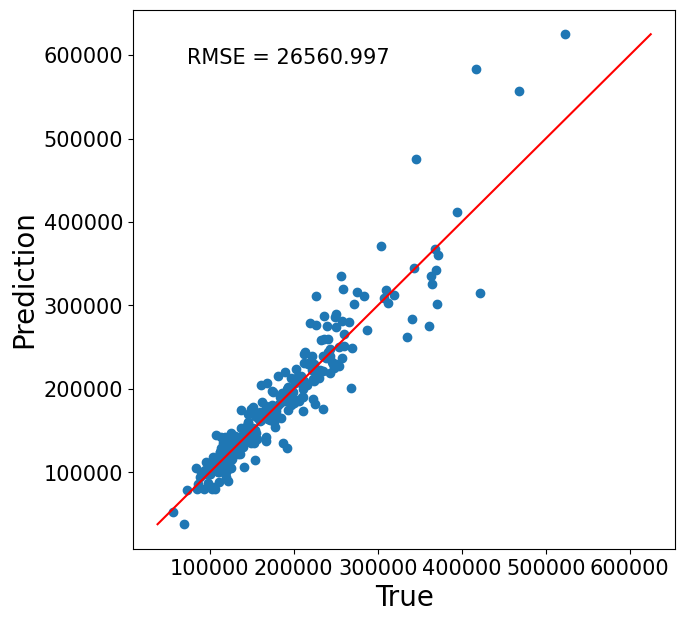

In [31]:
lgb_run(train_data, obj_column)